In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
#from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 10   # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 3
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0


print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  60000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [7]:
#준비된 데이터 (IID / NON-IID) np.array로


global_epoch = 0
acc, loss = 0, 0
cluster_acc, cluster_loss, Cluster_ACC, Cluster_LOSS = [], [], [], [] 
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
        TMP_w.extend(TMP_b) ##append 말고 더해야함..

        TMP_w = np.array(TMP_w)
        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    kmeans_model_w = KMeans(n_clusters = 1)   # 0, 1은 silhouette 에 안먹힘  

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 1  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 

    # ==========> 클러스터 갯수 정해짐


    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(1): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):
            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균


#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0
Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.5182 - accuracy: 0.8155
35/35 - 0s - loss: 0.4761 - accuracy: 0.8236
35/35 - 0s - loss: 0.5261 - accuracy: 0.8092
35/35 - 0s - loss: 0.5967 - accuracy: 0.7921
35/35 - 0s - loss: 0.5432 - accuracy: 0.7849
35/35 - 0s - loss: 0.4855 - accuracy: 0.8254
35/35 - 0s - loss: 0.5604 - accuracy: 0.7885
35/35 - 0s - loss: 0.5432 - accuracy: 0.7966
35/35 - 0s - loss: 0.5261 - accuracy: 0.8146
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time :  60.341618061065674 




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-7-e13bb5ddfd24>:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks th

In [8]:
G_epoch = 21

for global_epoch in range(1, G_epoch):

    for i in range(1, local):
        if global_epoch == 1:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)
        else:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['G{}_c_L{}_model'.format(global_epoch-1, i)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
    
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언
                    
                  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

    for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []

        for i in range(1, local):
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
            TMP_w.extend(TMP_b) ##append 말고 더해야함..

            TMP_w = np.array(TMP_w)
            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        kmeans_model_w = KMeans(n_clusters = 1)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])

        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 1  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
        

        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(1): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균


    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.5652 - accuracy: 0.7849
35/35 - 0s - loss: 0.5847 - accuracy: 0.7732
35/35 - 0s - loss: 0.6238 - accuracy: 0.7606
35/35 - 0s - loss: 0.6135 - accuracy: 0.7660
35/35 - 0s - loss: 0.6314 - accuracy: 0.7543
35/35 - 0s - loss: 0.5765 - accuracy: 0.7795
35/35 - 0s - loss: 0.6058 - accuracy: 0.7921
35/35 - 0s - loss: 0.5767 - accuracy: 0.7867
35/35 - 0s - loss: 0.6167 - accuracy: 0.7498
------------    1  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  60.36467504501343 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


2  번째 global_epoch 데이터 랜덤하게 준비!!
2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.5318 - accuracy: 0.8029
35/35 - 0s - loss: 0.4725 - accuracy: 0.8101
35/35 - 0s - loss: 0.5553 - accuracy: 0.8047
35/35 - 0s - loss: 0.5115 - accuracy: 0.8110
35/35 - 0s - loss: 0.5113 - accuracy: 0.8038
35/35 - 0s - loss: 0.5839 - accuracy: 0.7912
35/35 - 0s - loss: 0.5347 - accuracy: 0.7975
35/35 - 0s - loss: 0.5056 - accuracy: 0.8065
35/35 - 0s - loss: 0.5050 - accuracy: 0.8092
------------    2  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  59.78628873825073 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


3  번째 global_epoch 데이터 랜덤하게 준비!!
3  번째 global_epoch 데이터 랜덤 준비완료!!


3  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4868 - accuracy: 0.8218
35/35 - 0s - loss: 0.4280 - accuracy: 0.8281
35/35 - 0s - loss: 0.5012 - accuracy: 0.8092
35/35 - 0s - loss: 0.4465 - accuracy: 0.8452
35/35 - 0s - loss: 0.5133 - accuracy: 0.8029
35/35 - 0s - loss: 0.4441 - accuracy: 0.8290
35/35 - 0s - loss: 0.4769 - accuracy: 0.8173
35/35 - 0s - loss: 0.4105 - accuracy: 0.8488
35/35 - 0s - loss: 0.5126 - accuracy: 0.8029
------------    3  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  60.42699480056763 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


4  번째 global_epoch 데이터 랜덤하게 준비!!
4  번째 global_epoch 데이터 랜덤 준비완료!!


4  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4327 - accuracy: 0.8398
35/35 - 0s - loss: 0.4544 - accuracy: 0.8290
35/35 - 0s - loss: 0.4087 - accuracy: 0.8362
35/35 - 0s - loss: 0.4154 - accuracy: 0.8407
35/35 - 0s - loss: 0.4199 - accuracy: 0.8461
35/35 - 0s - loss: 0.4470 - accuracy: 0.8389
35/35 - 0s - loss: 0.3670 - accuracy: 0.8560
35/35 - 0s - loss: 0.4734 - accuracy: 0.8245
35/35 - 0s - loss: 0.4076 - accuracy: 0.8605
------------    4  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  60.317158222198486 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!
5  번째 global_epoch 데이터 랜덤 준비완료!!


5  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3811 - accuracy: 0.8605
35/35 - 0s - loss: 0.4208 - accuracy: 0.8461
35/35 - 0s - loss: 0.4155 - accuracy: 0.8506
35/35 - 0s - loss: 0.4055 - accuracy: 0.8569
35/35 - 0s - loss: 0.3971 - accuracy: 0.8677
35/35 - 0s - loss: 0.4066 - accuracy: 0.8488
35/35 - 0s - loss: 0.4119 - accuracy: 0.8407
35/35 - 0s - loss: 0.3931 - accuracy: 0.8470
35/35 - 0s - loss: 0.4086 - accuracy: 0.8497
------------    5  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  61.58380126953125 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


6  번째 global_epoch 데이터 랜덤하게 준비!!
6  번째 global_epoch 데이터 랜덤 준비완료!!


6  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3498 - accuracy: 0.8758
35/35 - 0s - loss: 0.3424 - accuracy: 0.8713
35/35 - 0s - loss: 0.4104 - accuracy: 0.8515
35/35 - 0s - loss: 0.3592 - accuracy: 0.8668
35/35 - 0s - loss: 0.4161 - accuracy: 0.8542
35/35 - 0s - loss: 0.4033 - accuracy: 0.8614
35/35 - 0s - loss: 0.3627 - accuracy: 0.8614
35/35 - 0s - loss: 0.3737 - accuracy: 0.8569
35/35 - 0s - loss: 0.3623 - accuracy: 0.8650
------------    6  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  61.173240423202515 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


7  번째 global_epoch 데이터 랜덤하게 준비!!
7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3296 - accuracy: 0.8722
35/35 - 0s - loss: 0.4001 - accuracy: 0.8524
35/35 - 0s - loss: 0.3418 - accuracy: 0.8794
35/35 - 0s - loss: 0.3837 - accuracy: 0.8596
35/35 - 0s - loss: 0.3757 - accuracy: 0.8569
35/35 - 0s - loss: 0.3563 - accuracy: 0.8686
35/35 - 0s - loss: 0.3809 - accuracy: 0.8623
35/35 - 0s - loss: 0.3484 - accuracy: 0.8722
35/35 - 0s - loss: 0.3733 - accuracy: 0.8659
------------    7  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  61.3852059841156 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


8  번째 global_epoch 데이터 랜덤하게 준비!!
8  번째 global_epoch 데이터 랜덤 준비완료!!


8  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3584 - accuracy: 0.8668
35/35 - 0s - loss: 0.3125 - accuracy: 0.8812
35/35 - 0s - loss: 0.3808 - accuracy: 0.8587
35/35 - 0s - loss: 0.3724 - accuracy: 0.8794
35/35 - 0s - loss: 0.3622 - accuracy: 0.8641
35/35 - 0s - loss: 0.3970 - accuracy: 0.8659
35/35 - 0s - loss: 0.3899 - accuracy: 0.8461
35/35 - 0s - loss: 0.4542 - accuracy: 0.8353
35/35 - 0s - loss: 0.3491 - accuracy: 0.8659
------------    8  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  62.53888249397278 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!
9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3286 - accuracy: 0.8938
35/35 - 0s - loss: 0.3775 - accuracy: 0.8641
35/35 - 0s - loss: 0.3379 - accuracy: 0.8812
35/35 - 0s - loss: 0.3803 - accuracy: 0.8749
35/35 - 0s - loss: 0.3638 - accuracy: 0.8686
35/35 - 0s - loss: 0.3461 - accuracy: 0.8740
35/35 - 0s - loss: 0.3026 - accuracy: 0.8893
35/35 - 0s - loss: 0.3333 - accuracy: 0.8758
35/35 - 0s - loss: 0.2887 - accuracy: 0.8875
------------    9  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  62.89053678512573 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


10  번째 global_epoch 데이터 랜덤하게 준비!!
10  번째 global_epoch 데이터 랜덤 준비완료!!


10  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3068 - accuracy: 0.8830
35/35 - 0s - loss: 0.3895 - accuracy: 0.8560
35/35 - 0s - loss: 0.4074 - accuracy: 0.8434
35/35 - 0s - loss: 0.3502 - accuracy: 0.8713
35/35 - 0s - loss: 0.3084 - accuracy: 0.8857
35/35 - 0s - loss: 0.3032 - accuracy: 0.8911
35/35 - 0s - loss: 0.3429 - accuracy: 0.8767
35/35 - 0s - loss: 0.3497 - accuracy: 0.8722
35/35 - 0s - loss: 0.3345 - accuracy: 0.8776
------------    10  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  61.852269887924194 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


11  번째 global_epoch 데이터 랜덤하게 준비!!
11  번째 global_epoch 데이터 랜덤 준비완료!!


11  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3587 - accuracy: 0.8785
35/35 - 0s - loss: 0.3250 - accuracy: 0.8857
35/35 - 0s - loss: 0.3565 - accuracy: 0.8812
35/35 - 0s - loss: 0.4016 - accuracy: 0.8704
35/35 - 0s - loss: 0.3503 - accuracy: 0.8830
35/35 - 0s - loss: 0.2861 - accuracy: 0.9037
35/35 - 0s - loss: 0.3452 - accuracy: 0.9001
35/35 - 0s - loss: 0.3633 - accuracy: 0.8848
35/35 - 0s - loss: 0.2918 - accuracy: 0.8776
------------    11  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  63.37643098831177 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


12  번째 global_epoch 데이터 랜덤하게 준비!!
12  번째 global_epoch 데이터 랜덤 준비완료!!


12  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.2968 - accuracy: 0.8983
35/35 - 0s - loss: 0.2782 - accuracy: 0.8920
35/35 - 0s - loss: 0.3534 - accuracy: 0.8857
35/35 - 0s - loss: 0.3078 - accuracy: 0.8929
35/35 - 0s - loss: 0.3538 - accuracy: 0.8839
35/35 - 0s - loss: 0.3726 - accuracy: 0.8776
35/35 - 0s - loss: 0.3660 - accuracy: 0.8776
35/35 - 0s - loss: 0.3051 - accuracy: 0.8884
35/35 - 0s - loss: 0.3428 - accuracy: 0.8668
------------    12  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  63.2716805934906 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!
13  번째 global_epoch 데이터 랜덤 준비완료!!


13  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4167 - accuracy: 0.8857
35/35 - 0s - loss: 0.3650 - accuracy: 0.8686
35/35 - 0s - loss: 0.3737 - accuracy: 0.8650
35/35 - 0s - loss: 0.3576 - accuracy: 0.8740
35/35 - 0s - loss: 0.3599 - accuracy: 0.8731
35/35 - 0s - loss: 0.3261 - accuracy: 0.8911
35/35 - 0s - loss: 0.3936 - accuracy: 0.8587
35/35 - 0s - loss: 0.3767 - accuracy: 0.8686
35/35 - 0s - loss: 0.3407 - accuracy: 0.8803
------------    13  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  62.550957918167114 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


14  번째 global_epoch 데이터 랜덤하게 준비!!
14  번째 global_epoch 데이터 랜덤 준비완료!!


14  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3503 - accuracy: 0.8767
35/35 - 0s - loss: 0.3521 - accuracy: 0.8857
35/35 - 0s - loss: 0.3203 - accuracy: 0.8866
35/35 - 0s - loss: 0.3469 - accuracy: 0.8929
35/35 - 0s - loss: 0.2954 - accuracy: 0.8902
35/35 - 0s - loss: 0.2907 - accuracy: 0.8974
35/35 - 0s - loss: 0.3691 - accuracy: 0.8812
35/35 - 0s - loss: 0.3155 - accuracy: 0.8965
35/35 - 0s - loss: 0.3162 - accuracy: 0.8983
------------    14  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  63.98109316825867 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.4082 - accuracy: 0.8668
35/35 - 0s - loss: 0.3144 - accuracy: 0.8938
35/35 - 0s - loss: 0.3412 - accuracy: 0.8893
35/35 - 0s - loss: 0.3158 - accuracy: 0.8929
35/35 - 0s - loss: 0.3483 - accuracy: 0.8740
35/35 - 0s - loss: 0.2994 - accuracy: 0.8812
35/35 - 0s - loss: 0.3444 - accuracy: 0.8857
35/35 - 0s - loss: 0.3176 - accuracy: 0.8938
35/35 - 0s - loss: 0.3186 - accuracy: 0.8920
------------    15  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  63.486088037490845 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


16  번째 global_epoch 데이터 랜덤하게 준비!!
16  번째 global_epoch 데이터 랜덤 준비완료!!


16  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3295 - accuracy: 0.9019
35/35 - 0s - loss: 0.2776 - accuracy: 0.9091
35/35 - 0s - loss: 0.3131 - accuracy: 0.8911
35/35 - 0s - loss: 0.2959 - accuracy: 0.8893
35/35 - 0s - loss: 0.3441 - accuracy: 0.8803
35/35 - 0s - loss: 0.3250 - accuracy: 0.8857
35/35 - 0s - loss: 0.4572 - accuracy: 0.8704
35/35 - 0s - loss: 0.3202 - accuracy: 0.8965
35/35 - 0s - loss: 0.2940 - accuracy: 0.9001
------------    16  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  62.85242962837219 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


17  번째 global_epoch 데이터 랜덤하게 준비!!
17  번째 global_epoch 데이터 랜덤 준비완료!!


17  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3114 - accuracy: 0.8875
35/35 - 0s - loss: 0.3289 - accuracy: 0.8965
35/35 - 0s - loss: 0.2499 - accuracy: 0.9037
35/35 - 0s - loss: 0.3191 - accuracy: 0.8839
35/35 - 0s - loss: 0.3148 - accuracy: 0.8893
35/35 - 0s - loss: 0.3563 - accuracy: 0.8902
35/35 - 0s - loss: 0.3824 - accuracy: 0.8839
35/35 - 0s - loss: 0.3478 - accuracy: 0.8902
35/35 - 0s - loss: 0.3180 - accuracy: 0.8929
------------    17  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  63.6200795173645 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


18  번째 global_epoch 데이터 랜덤하게 준비!!
18  번째 global_epoch 데이터 랜덤 준비완료!!


18  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3485 - accuracy: 0.8740
35/35 - 0s - loss: 0.3339 - accuracy: 0.8929
35/35 - 0s - loss: 0.3258 - accuracy: 0.8875
35/35 - 0s - loss: 0.2590 - accuracy: 0.9010
35/35 - 0s - loss: 0.3673 - accuracy: 0.8893
35/35 - 0s - loss: 0.3332 - accuracy: 0.9010
35/35 - 0s - loss: 0.2798 - accuracy: 0.8992
35/35 - 0s - loss: 0.2794 - accuracy: 0.8947
35/35 - 0s - loss: 0.2804 - accuracy: 0.9046
------------    18  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  65.6502013206482 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


19  번째 global_epoch 데이터 랜덤하게 준비!!
19  번째 global_epoch 데이터 랜덤 준비완료!!


19  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3939 - accuracy: 0.8929
35/35 - 0s - loss: 0.3442 - accuracy: 0.8929
35/35 - 0s - loss: 0.3240 - accuracy: 0.9091
35/35 - 0s - loss: 0.2926 - accuracy: 0.8992
35/35 - 0s - loss: 0.3142 - accuracy: 0.8884
35/35 - 0s - loss: 0.3577 - accuracy: 0.8821
35/35 - 0s - loss: 0.3135 - accuracy: 0.8974
35/35 - 0s - loss: 0.3843 - accuracy: 0.8821
35/35 - 0s - loss: 0.3497 - accuracy: 0.8776
------------    19  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  64.8205099105835 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================


20  번째 global_epoch 데이터 랜덤하게 준비!!
20  번째 global_epoch 데이터 랜덤 준비완료!!


20  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

35/35 - 0s - loss: 0.3636 - accuracy: 0.8794
35/35 - 0s - loss: 0.3105 - accuracy: 0.8902
35/35 - 0s - loss: 0.3203 - accuracy: 0.8938
35/35 - 0s - loss: 0.3257 - accuracy: 0.8974
35/35 - 0s - loss: 0.2954 - accuracy: 0.9010
35/35 - 0s - loss: 0.3221 - accuracy: 0.8893
35/35 - 0s - loss: 0.3767 - accuracy: 0.8767
35/35 - 0s - loss: 0.2965 - accuracy: 0.8983
35/35 - 0s - loss: 0.3148 - accuracy: 0.8992
------------    20  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  64.49807047843933 ---------------------------




C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
C:\Users\hlee185\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a



====================================================== One Global Epoch =====================================================================




<ipython-input-8-b4dc9b3fb347>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


In [9]:
L0_label0, L0_label1, L0_label2 = 0, 0, 0 
L1_label0, L1_label1, L1_label2 = 0, 0, 0 
L2_label0, L2_label1, L2_label2 = 0, 0, 0 
L3_label0, L3_label1, L3_label2 = 0, 0, 0 
L4_label0, L4_label1, L4_label2 = 0, 0, 0 


for i in range(int(len(label_list)/5)):
    for k in range(5):
        for j in range(len(label_list[0])):
            if label_list[i*5 + k][j] == 0:
                  globals()['L{}_label0'.format(k)] = globals()['L{}_label0'.format(k)] + 1 

            elif label_list[i*5 + k][j] == 1:
                globals()['L{}_label1'.format(k)] = globals()['L{}_label1'.format(k)] + 1

            elif label_list[i*5 + k][j] == 2:
                globals()['L{}_label2'.format(k)] = globals()['L{}_label2'.format(k)] + 1


print("Layer 0  ==> label 0, 1, 2 갯수 : ", L0_label0, L0_label1, L0_label2)
print("Layer 2  ==> label 0, 1, 2 갯수 : ", L1_label0, L1_label1, L1_label2)
print("Layer 4  ==> label 0, 1, 2 갯수 : ", L2_label0, L2_label1, L2_label2)
print("Layer 6  ==> label 0, 1, 2 갯수 : ", L3_label0, L3_label1, L3_label2)
print("Layer 7  ==> label 0, 1, 2 갯수 : ", L4_label0, L4_label1, L4_label2)

Layer 0  ==> label 0, 1, 2 갯수 :  189 0 0
Layer 2  ==> label 0, 1, 2 갯수 :  189 0 0
Layer 4  ==> label 0, 1, 2 갯수 :  189 0 0
Layer 6  ==> label 0, 1, 2 갯수 :  189 0 0
Layer 7  ==> label 0, 1, 2 갯수 :  189 0 0


In [10]:
num_cluster = 1

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[0.0015386026, 0.0064171273, 0.0119087435, 0.016998746, 0.022206852, 0.027302666, 0.032352436, 0.036640033, 0.040516302, 0.043949053, 0.048062954, 0.051330045, 0.054662015, 0.057282157, 0.059940055, 0.0626084, 0.06496373, 0.06703295, 0.069573425, 0.072483525]
[0.0004969785, 0.0029056952, 0.005296901, 0.0068547535, 0.008132795, 0.0092230905, 0.010153853, 0.011002197, 0.011838967, 0.012622161, 0.013414115, 0.014164146, 0.014898545, 0.015598887, 0.016261132, 0.016923096, 0.01754336, 0.018133504, 0.01871248, 0.019278632]
[0.00029796478, 0.00083975744, 0.0014376957, 0.0019457585, 0.0024158678, 0.0028600853, 0.003292816, 0.0037005171, 0.004107664, 0.0045101834, 0.0049021007, 0.005285294, 0.005653403, 0.006013101, 0.0063658115, 0.006705529, 0.0070325295, 0.007363034, 0.007694966, 0.008001826]
[0.00

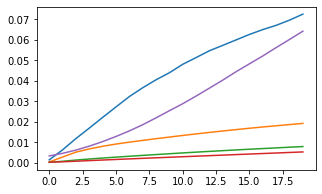

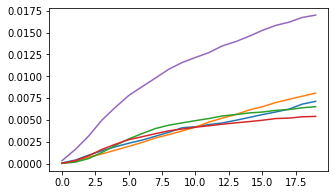

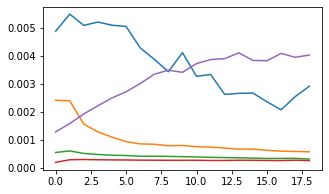

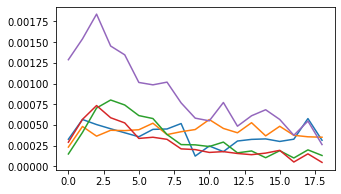

In [11]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        sumss_w, sumss_b = 0, 0
        for sks in range(num_cluster):
            sumss_w = sumss_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][0] 
            sumss_b = sumss_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][1]

        sumss_w = sumss_w/num_cluster
        sumss_b = sumss_b/num_cluster

        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var( sumss_w ))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var( sumss_b ))
        
        

for layer_index in num_layers_list:
    for tmp_int in range(len(globals()['var_accumulate_L{}_w'.format(layer_index)])-1):
        minus_w = globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int]
        minus_b = globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int]        
        globals()['var_changes_L{}_w'.format(layer_index)].append( minus_w )
        globals()['var_changes_L{}_b'.format(layer_index)].append( minus_b )
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.044112172, 0.026032515, 0.019026907, 0.015167978, 0.012448158, 0.012404845, 0.011190563, 0.010465458, 0.009479503, 0.008243415, 0.0069823763, 0.0072421413, 0.0061996174, 0.006080472, 0.005916288, 0.0053067375, 0.005314303, 0.005939488, 0.005268981, 0.0051205475]
[0.038393207, 0.025603898, 0.019980885, 0.017708084, 0.0138706565, 0.012561608, 0.011743669, 0.010564651, 0.009874354, 0.009933975, 0.009602841, 0.008810538, 0.0087350225, 0.0088721635, 0.008141007, 0.008079773, 0.0076255593, 0.007659363, 0.007355282, 0.0072081727]
[0.0182926, 0.01681178, 0.014389662, 0.011754651, 0.009317686, 0.007823298, 0.0068600327, 0.006497504, 0.0061494177, 0.00568755, 0.0054703834, 0.0056987773, 0.0050517535, 0.005388237, 0.0049899984, 0.0052631455, 0.0048507773, 0.004804738, 0.004889847, 0.0046189656]
[0.015339766, 0.013976702, 0.010750166, 0.008250706, 0.0071645677, 0.005577077

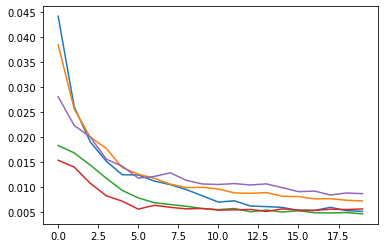

In [12]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch):    
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        if global_epoch >0:
            globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.037621584, 0.07185501, 0.08950409, 0.10063628, 0.11017719, 0.11828237, 0.12544434, 0.13215692, 0.13911809, 0.14500144, 0.15004496, 0.15474746, 0.1591435, 0.16339268, 0.16792706, 0.17200583, 0.17580543, 0.17956635, 0.18393506, 0.18753977]
[0.02101612, 0.04766593, 0.063665725, 0.0719567, 0.0795916, 0.08624758, 0.09222817, 0.09812796, 0.10290801, 0.10747477, 0.11185127, 0.11624096, 0.11989829, 0.123061605, 0.12673633, 0.1294989, 0.13272351, 0.13510871, 0.13747203, 0.13981953]
[0.016661607, 0.02845278, 0.039971508, 0.051058434, 0.06007029, 0.0668212, 0.07207705, 0.07651868, 0.0801011, 0.0831379, 0.08567281, 0.08809595, 0.09040577, 0.09222489, 0.094129845, 0.09562629, 0.09728875, 0.09892301, 0.100576214, 0.102003016]
[0.017818145, 0.026480896, 0.03578165, 0.04413366, 0.049980804, 0.054819804, 0.058167722, 0.061172757, 0.064146705, 0.066339836, 0.06840826, 0.07045674

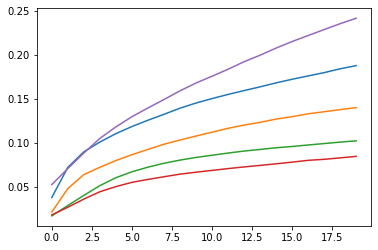

In [13]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch-1):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

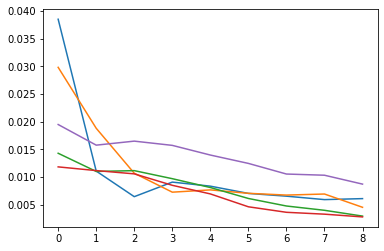

In [14]:
import matplotlib.pyplot as plt

s0 = [0.03510154, 0.0736385, 0.08473158, 0.09120098, 0.100300536, 0.108670846, 0.115726866, 0.122285396, 0.12822285, 0.1343392]
s1 = [0.02099476, 0.050841495, 0.069671765, 0.080376655, 0.087658435, 0.095351465, 0.1024259, 0.10918266, 0.11613044, 0.12067786]
s2 = [0.016447905, 0.030761698, 0.04178885, 0.05296351, 0.06268379, 0.07080734, 0.07694943, 0.08173024, 0.08573541, 0.08869333]
s3 = [0.017731152, 0.029584156, 0.040767536, 0.05135955, 0.05988145, 0.066847235, 0.071486555, 0.07513058, 0.07843605, 0.081245504]
s4 = [0.05253297, 0.07204267, 0.08782311, 0.104330085, 0.1200701, 0.13406195, 0.14654286, 0.15710238, 0.1674462, 0.17618415] 

s0_diff, s1_diff, s2_diff, s3_diff, s4_diff = [], [], [], [], []

for i in range(len(s0)-1):
    s0_diff.append(s0[i+1] - s0[i])
    s1_diff.append(s1[i+1] - s1[i])
    s2_diff.append(s2[i+1] - s2[i])
    s3_diff.append(s3[i+1] - s3[i])
    s4_diff.append(s4[i+1] - s4[i])


plt.plot(s0_diff)
plt.plot(s1_diff)
plt.plot(s2_diff)
plt.plot(s3_diff)
plt.plot(s4_diff)

[[0.8154815435409546, 0.8235823512077332, 0.8091809153556824, 0.7920792102813721, 0.7848784923553467, 0.8253825306892395, 0.7884788513183594, 0.7965796589851379, 0.8145814538002014], [0.7848784923553467, 0.7731773257255554, 0.760576069355011, 0.76597660779953, 0.7542754411697388, 0.7794779539108276, 0.7920792102813721, 0.786678671836853, 0.7497749924659729], [0.8028802871704102, 0.8100810050964355, 0.8046804666519165, 0.8109810948371887, 0.8037803769111633, 0.7911791205406189, 0.7974797487258911, 0.8064806461334229, 0.8091809153556824], [0.8217821717262268, 0.828082799911499, 0.8091809153556824, 0.8451845049858093, 0.8028802871704102, 0.8289828896522522, 0.8172817230224609, 0.848784863948822, 0.8028802871704102], [0.8397839665412903, 0.8289828896522522, 0.8361836075782776, 0.8406840562820435, 0.8460845947265625, 0.8388838768005371, 0.8559855818748474, 0.8244824409484863, 0.8604860305786133], [0.8604860305786133, 0.8460845947265625, 0.8505850434303284, 0.8568856716156006, 0.867686748504

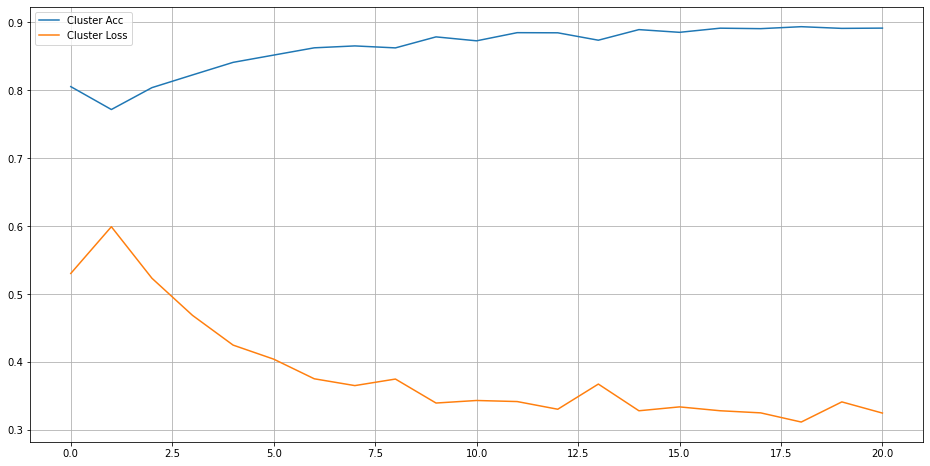

In [15]:
average_acc_cluster_list, average_loss_cluster_list = [], []


for i in range(len(Cluster_ACC)):    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    
plt.figure(figsize=(16,8))
plt.plot(average_acc_cluster_list, label='Cluster Acc')
print(Cluster_ACC)
print(Cluster_LOSS,"\n\n\n")
plt.plot(average_loss_cluster_list, label='Cluster Loss')

plt.grid(True)
plt.legend()
plt.show()


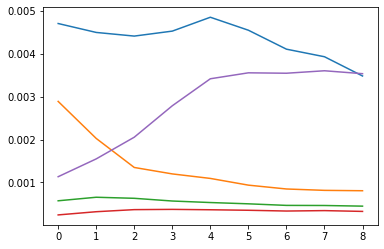

In [16]:
a0 = [0.0047102934, 0.004502174, 0.0044169966, 0.0045330757, 0.004856793, 0.004553752, 0.0041116737, 0.0039348826, 0.0034856796]
a1 = [0.002892374, 0.0020282047, 0.0013507195, 0.001200153, 0.0010949243, 0.0009381408, 0.0008484423, 0.0008163415, 0.0008076085]
a2 = [0.00057295227, 0.0006555882, 0.00063094834, 0.0005676171, 0.0005321214, 0.0005020681, 0.0004655139, 0.00046304846, 0.0004479466]
a3 = [0.00024321573, 0.0003179367, 0.00036643253, 0.00037250028, 0.00036362524, 0.00035164272, 0.00033380813, 0.00034366432, 0.0003250935]
a4 = [0.0011350878, 0.0015507787, 0.002057082, 0.0027908236, 0.0034208614, 0.003559691, 0.0035501122, 0.0036076512, 0.0035394672]

plt.plot(a0)
plt.plot(a1)
plt.plot(a2)
plt.plot(a3)
plt.plot(a4)